In [15]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import wandb

In [ ]:
!wandb login fbe7eed55549434c72b14d9e1879d65d6d8cda51
run = wandb.init()

In [26]:
artifact = run.use_artifact('usmanali105-information-technology-university/lightning_logs/model-mhrqxi72:v52', type='model')
artifact_dir = artifact.download(root='checkpoints')

wandb: Downloading large artifact model-mhrqxi72:v52, 309.81MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.3


In [27]:
MODEL_CHECKPOINT_PATH = r'checkpoints/model.ckpt'
if os.path.exists(MODEL_CHECKPOINT_PATH):
    print(f"{MODEL_CHECKPOINT_PATH} OKAY")
else:
    print(f"{MODEL_CHECKPOINT_PATH} NOT OKAY")

checkpoints/model.ckpt OKAY


In [18]:
from text_recognizer.data.iam_lines import IAMLines
from text_recognizer.models.line_cnn_transformer import LineCNNTransformer
from text_recognizer import lit_models

In [19]:
data = IAMLines()
data.prepare_data()
data.setup()

In [20]:
class Args:
    def __init__(self):
        self.tf_dim = 512
        self.tf_fc_dim = 2048
        self.tf_dropout = 0.2
        self.tf_layers = 6
        self.tf_nhead = 8

args = Args()

model = LineCNNTransformer(data_config=data.config(), args=args)

In [21]:
mapping = data.mapping
start_token = model.start_token
end_token = model.end_token
padding_token = model.padding_token
print(f"Special tokens: START={start_token}, END={end_token}, PAD={padding_token}")
def decode(preds, mapping, start_token=1, end_token=2, padding_token=3):
    chars = []
    for p in preds.tolist():
        if p == end_token:
            break
        if p != start_token and p != padding_token:
            chars.append(mapping[p])
    return ''.join(chars)

Special tokens: START=1, END=2, PAD=3


In [22]:
val_dataset = data.data_val

In [28]:
print("Loading model from checkpoint...")
lit_model = lit_models.TransformerLitModel.load_from_checkpoint(
    MODEL_CHECKPOINT_PATH,
    model=model,
    args=args,
    strict=False
)
lit_model.eval()

Loading model from checkpoint...


TransformerLitModel(
  (model): LineCNNTransformer(
    (line_cnn): LineCNN(
      (convs): Sequential(
        (0): ConvBlock(
          (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU()
        )
        (1): ConvBlock(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU()
        )
        (2): ConvBlock(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (relu): ReLU()
        )
        (3): ConvBlock(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU()
        )
        (4): ConvBlock(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (relu): ReLU()
        )
        (5): ConvBlock(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU()
        )
        (6): ConvBlock(
          (conv

In [ ]:
num_samples = 4
plt.figure(figsize=(20, 4 * num_samples))
indices = np.random.choice(len(val_dataset), min(num_samples, len(val_dataset)), replace=False)

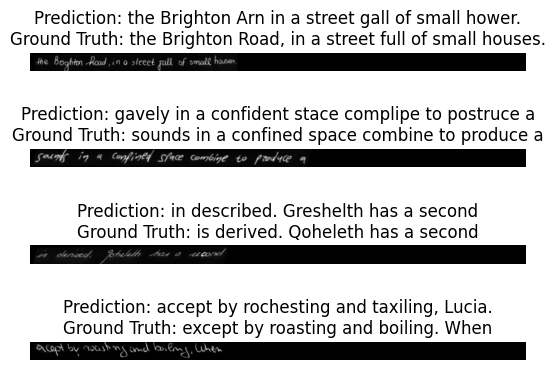

In [33]:
samples_visualized = 0
with torch.no_grad():
    for idx in indices:
        x, y = val_dataset[idx]
        x = x.unsqueeze(0)
        y_pred = lit_model.model(x)
        y_pred_tokens = y_pred[0].cpu().numpy()
        y_pred_str = []
        for token_idx in y_pred_tokens:
            if token_idx == padding_token or token_idx == end_token:
                break
            if token_idx != start_token:
                y_pred_str.append(mapping[token_idx])
        y_pred_str = "".join(y_pred_str)
        y_true_tokens = y.cpu().numpy()
        y_true_str = []
        for token_idx in y_true_tokens:
            if token_idx == padding_token or token_idx == end_token:
                break
            if token_idx != start_token:
                y_true_str.append(mapping[token_idx])
        y_true_str = "".join(y_true_str)
        plt.subplot(num_samples, 1, samples_visualized + 1)
        plt.imshow(x[0].cpu().numpy().squeeze(), cmap="gray")
        plt.title(f"Prediction: {y_pred_str}\nGround Truth: {y_true_str}")
        plt.axis("off")
        samples_visualized += 1